In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')

In [3]:
# import scanpy as sc 

# adata = sc.read_h5ad('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_filtered85.h5ad')

# # I think these embeddings were only using the beta chain
# adata.obs['cdr3_b']

In [4]:
datadir = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data'

with open(f'{datadir}/KIR+TEDDY_D2V_vecs_beta_k7_FI.pkl', 'rb') as f:
    d2v_embeds = np.array(pickle.load(f))

d2v_embeds.shape

(10191, 128)

In [5]:
# use an MLP to reconstruct the TCR from the embedding?

esm2_embeds = np.load(f'{datadir}/ESM2_PCA32_KIR+TEDDY.npy')
esm2_embeds.shape

(10191, 32)

In [6]:
import sys
sys.path.append('../src')

from models import SimpleNN, EmbeddingDataset
from torch.utils.data import DataLoader

In [7]:
dataset = EmbeddingDataset(X=esm2_embeds, y=d2v_embeds)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = SimpleNN(
    input_dim=esm2_embeds.shape[1], 
    output_dim=d2v_embeds.shape[1]
)

Epoch 199 loss: 0.004335732199251652: 100%|██████████| 200/200 [00:44<00:00,  4.53it/s] 


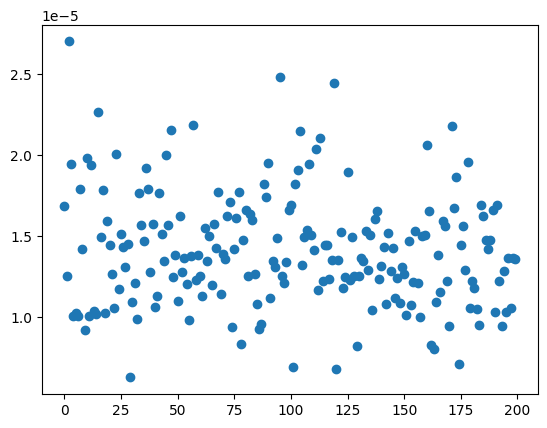

In [8]:
model.train(dataloader, epochs=200)
plt.scatter(range(200), model.losses)

In [ ]:
from deletion import EmbeddingEvaluator

evaluator = EmbeddingEvaluator(model=None)
errorMLP = evaluator.get_contributions(esm2_embeds, y=d2v_embeds)

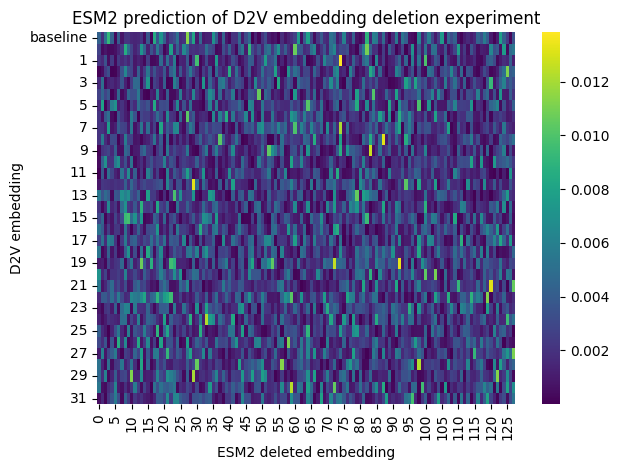

In [31]:
df = errorMLP.mean(axis=1)
df = pd.DataFrame(abs(df), index=['baseline'] + list(range(0, 32)))
sns.heatmap(df, cmap='viridis')
plt.title('ESM2 prediction of D2V embedding deletion experiment')
plt.xlabel('ESM2 deleted embedding')
plt.ylabel('D2V embedding')
plt.tight_layout()

In [27]:
evaluator = EmbeddingEvaluator(model=model)
errorNN = evaluator.get_contributions(esm2_embeds, y=d2v_embeds)

Performing deletion experiments...: 100%|██████████| 32/32 [22:11<00:00, 41.59s/it]


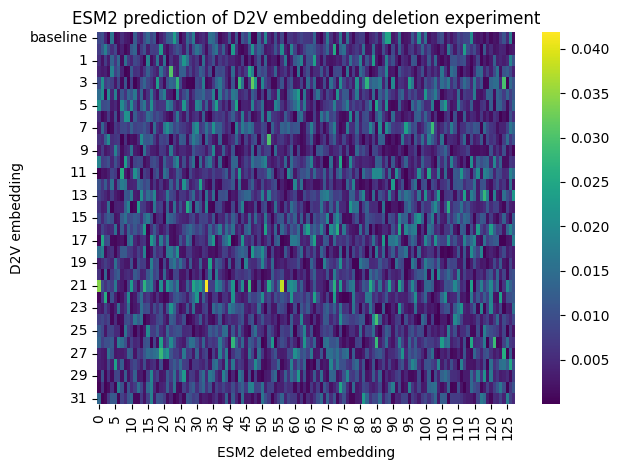

In [32]:
df = errorNN.mean(axis=1)
df = pd.DataFrame(abs(df), index=['baseline'] + list(range(0, 32)))
sns.heatmap(df, cmap='viridis')
plt.title('ESM2 prediction of D2V embedding deletion experiment')
plt.xlabel('ESM2 deleted embedding')
plt.ylabel('D2V embedding')
plt.tight_layout()